2024-07-14 03:33:46.073610: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 03:33:46.073723: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 03:33:46.195868: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0
0.4.23
Interactive? False
368
(TensorSpec(shape=(None, 556), dtype=tf.float32, name=None), TensorSpec(shape=(None, 368), dtype=tf.float32, name=None))


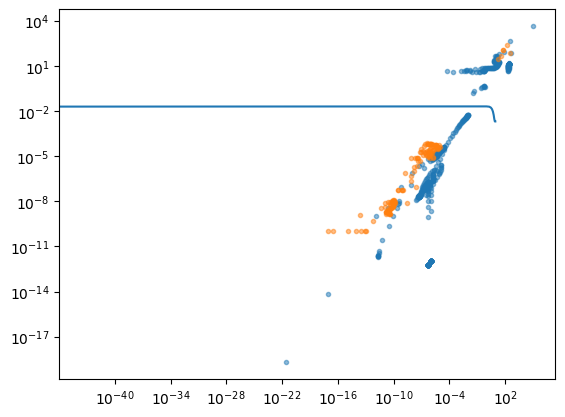

In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"

import gc
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

import tensorflow as tf
import jax
import keras

from sklearn import metrics
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, Flatten

from tqdm.notebook import tqdm

print(tf.__version__)
print(jax.__version__)

def is_interactive():
    return 'runtime' in get_ipython().config.IPKernelApp.connection_file

print('Interactive?', is_interactive())

SEED = 42
keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

DATA = "/kaggle/input/leap-atmospheric-physics-ai-climsim"
DATA_TFREC = "/kaggle/input/leap-train-tfrecords"

sample = pl.read_csv(os.path.join(DATA, "sample_submission.csv"), n_rows=1)
TARGETS = sample.select(pl.exclude('sample_id')).columns
print(len(TARGETS))

def _parse_function(example_proto):
    feature_description = {
        'x': tf.io.FixedLenFeature([556], tf.float32),
        'targets': tf.io.FixedLenFeature([368], tf.float32)
    }
#     x = e['x']
#     targets = e['targets'][:360]  # Select the first 360 features
    e = tf.io.parse_single_example(example_proto, feature_description)
    return e['x'], e['targets']

train_files = [os.path.join(DATA_TFREC, "train_%.3d.tfrec" % i) for i in range(100)]
valid_files = [os.path.join(DATA_TFREC, "train_%.3d.tfrec" % i) for i in range(100, 101)]

BATCH_SIZE = 1024

train_options = tf.data.Options()
train_options.deterministic = True

ds_train = (
    tf.data.Dataset.from_tensor_slices(train_files)
    .with_options(train_options)
    .shuffle(100)
    .interleave(
        lambda file: tf.data.TFRecordDataset(file).map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE),
        num_parallel_calls=tf.data.AUTOTUNE,
        cycle_length=10,
        block_length=1000,
        deterministic=True
    )
    .shuffle(4 * BATCH_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

ds_valid = (
    tf.data.TFRecordDataset(valid_files)
    .map(_parse_function)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

print(ds_train.element_spec)

norm_x = keras.layers.Normalization()
norm_x.adapt(ds_train.map(lambda x, y: x).take(20 if is_interactive() else 1000))

plt.scatter(
    norm_x.mean.squeeze(),
    norm_x.variance.squeeze() ** 0.5,
    marker=".",
    alpha=0.5
)
plt.xscale('log')
plt.yscale('log')

norm_y = keras.layers.Normalization()
norm_y.adapt(ds_train.map(lambda x, y: y).take(20 if is_interactive() else 1000))

mean_y = norm_y.mean
stdd_y = keras.ops.maximum(1e-10, norm_y.variance ** 0.5)

plt.scatter(
    mean_y.squeeze(),
    stdd_y.squeeze(),
    marker=".",
    alpha=0.5
)
plt.xscale('log')
plt.yscale('log')


min_y = np.min(np.stack([np.min(yb, 0) for _, yb in ds_train.take(20 if is_interactive() else 1000)], 0), 0, keepdims=True)
max_y = np.max(np.stack([np.max(yb, 0) for _, yb in ds_train.take(20 if is_interactive() else 1000)], 0), 0, keepdims=True)

### Model definition & Training

@keras.saving.register_keras_serializable(package="MyMetrics", name="ClippedR2Score")
class ClippedR2Score(keras.metrics.Metric):
    def __init__(self, name='r2_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.base_metric = keras.metrics.R2Score(class_aggregation=None)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.base_metric.update_state(y_true, y_pred, sample_weight=None)
        
    def result(self):
        return keras.ops.mean(keras.ops.clip(self.base_metric.result(), 0.0, 1.0))
        
    def reset_states(self):
        self.base_metric.reset_states()

epochs = 10 # 25  # 15  # 12
learning_rate = 2e-2

epochs_warmup = 1
epochs_ending = 2
steps_per_epoch = int(np.ceil(len(train_files) * 100_000 / BATCH_SIZE))

lr_scheduler = keras.optimizers.schedules.CosineDecay(
    1e-2, 
    (epochs - epochs_warmup - epochs_ending) * steps_per_epoch, 
    warmup_target=learning_rate,
    warmup_steps=steps_per_epoch * epochs_warmup,
    alpha=0.1
)

plt.plot([lr_scheduler(it) for it in range(0, epochs * steps_per_epoch, steps_per_epoch)]);

In [2]:
# keras.utils.clear_session()

# def x_to_seq(x):
#     x_seq0 = keras.ops.transpose(keras.ops.reshape(x[:, 0:60 * 6], (-1, 6, 60)), (0, 2, 1))
#     x_seq1 = keras.ops.transpose(keras.ops.reshape(x[:, 60 * 6 + 16:60 * 9 + 16], (-1, 3, 60)), (0, 2, 1))
#     x_flat = keras.ops.reshape(x[:, 60 * 6:60 * 6 + 16], (-1, 1, 16))
#     x_flat = keras.ops.repeat(x_flat, 60, axis=1)
#     return keras.ops.concatenate([x_seq0, x_seq1, x_flat], axis=-1)


# def build_cnn(activation='relu'):    
#     return keras.Sequential([
# #         keras.layers.Conv1D(500, 3, padding='same', activation=activation),
# #         keras.layers.BatchNormalization(),
# #         keras.layers.Conv1D(512, 4, padding='same', activation=activation),
# #         keras.layers.BatchNormalization(),
#         keras.layers.Conv1D(328, 5, padding='same', activation=activation),
#         keras.layers.BatchNormalization(),
#         keras.layers.Conv1D(256, 5, padding='same', activation=activation),
#         keras.layers.BatchNormalization(),
#         keras.layers.Conv1D(128, 5, padding='same', activation=activation),
#         keras.layers.BatchNormalization(),
#         keras.layers.Conv1D(64, 5, padding='same', activation=activation),
#         keras.layers.BatchNormalization(),
#     ])


# X_input = x = keras.layers.Input(ds_train.element_spec[0].shape[1:])
# x = keras.layers.Normalization(mean=norm_x.mean, variance=norm_x.variance)(x)
# x = x_to_seq(x)

# # e = e0 = keras.layers.Conv1D(64, 1, padding='same')(x)
# # # e = keras.layers.BatchNormalization()(e)
# # e = build_cnn()(e)
# # # add global average to allow some comunication between all levels even in a small CNN
# # e = e + keras.layers.GlobalAveragePooling1D(keepdims=True)(e) + e0
# # e = e1 = keras.layers.BatchNormalization()(e)
# # # e = build_cnn()(e)
# # # # e = e + e1 + keras.layers.GlobalAveragePooling1D(keepdims=True)(e1)
# # e = build_cnn()(e)
# # e = e + keras.layers.GlobalAveragePooling1D(keepdims=True)(e) + e1
# # e = keras.layers.BatchNormalization()(e)
# # e = build_cnn()(e)

# e = e0 = keras.layers.Conv1D(64, 1, padding='same')(x)
# e = build_cnn()(e)
# # add global average to allow some comunication between all levels even in a small CNN
# e = e0 + e + keras.layers.GlobalAveragePooling1D(keepdims=True)(e)
# # e = keras.layers.BatchNormalization()(e)
# # e1 = build_cnn()(e)
# # e = e + e1 + keras.layers.GlobalAveragePooling1D(keepdims=True)(e1)
# e = keras.layers.BatchNormalization()(e)
# e = e + build_cnn()(e) + keras.layers.GlobalAveragePooling1D(keepdims=True)(e)
# e = keras.layers.BatchNormalization()(e)
# e = e + build_cnn()(e) + keras.layers.GlobalAveragePooling1D(keepdims=True)(e)
# e = keras.layers.BatchNormalization()(e)
# e = keras.layers.BatchNormalization()(e)
# e = e + build_cnn()(e) + keras.layers.GlobalAveragePooling1D(keepdims=True)(e)
# e = keras.layers.BatchNormalization()(e)
# # p_all = keras.layers.Conv1D(14, 1, padding='same')(e)

# # p_seq = p_all[:, :, :6]
# # p_seq = keras.ops.transpose(p_seq, (0, 2, 1))
# # p_seq = keras.layers.Flatten()(p_seq)
# # assert p_seq.shape[-1] == 360

# p_seq = keras.layers.Conv1D(6, 1, padding='same')(e)
# p_seq = keras.ops.transpose(p_seq, (0, 2, 1))
# p_seq = keras.layers.Flatten()(p_seq)
# assert p_seq.shape[-1] == 360

# # p_flat = p_all[:, :, 6:6 + 8]
# # p_flat = keras.ops.mean(p_flat, axis=1)
# # assert p_flat.shape[-1] == 8


# p_flat = keras.layers.Conv1D(8, 1, padding='same')(e)
# p_flat = keras.ops.mean(p_flat, axis=1)
# assert p_flat.shape[-1] == 8

# P = keras.ops.concatenate([p_seq, p_flat], axis=1)

# # P = keras.layers.Dense(1024, activation='relu')(P)
# # # P = keras.layers.Dropout(0.3)(P)
# # P = keras.layers.Dense(750, activation='relu')(P)
# # P = keras.layers.Dense(368, activation='relu')(P)
# # P = keras.layers.Dropout(0.3)(P)

# # # Output layer
# # output = keras.layers.Dense(368, activation='linear')(P)

# # build & compile
# model = keras.Model(X_input, P)
# model.compile(
#     loss='mse', 
#     optimizer=keras.optimizers.Adam(lr_scheduler),
#     metrics=[ClippedR2Score()]
# )
# model.build(tuple(ds_train.element_spec[0].shape))
# model.summary()

In [3]:
model = tf.keras.models.load_model('/kaggle/input/cnn-max/CNN_model_10th_JUL_2_ep.keras')

In [4]:
ds_train_target_normalized = ds_train.map(lambda x, y: (x, (y - mean_y) / stdd_y))
ds_valid_target_normalized = ds_valid.map(lambda x, y: (x, (y - mean_y) / stdd_y))

history = model.fit(
    ds_train_target_normalized,
    validation_data=ds_valid_target_normalized,
    epochs=epochs,
    verbose=1 if is_interactive() else 2,
    callbacks=[
        keras.callbacks.ModelCheckpoint(filepath='model.keras')
    ]
)

Epoch 1/10


2024-07-14 03:35:33.742825: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{k11=2} for conv (f32[1024,256,60]{2,1,0}, u8[0]{0}) custom-call(f32[1024,128,60]{2,1,0}, f32[128,256,5]{2,1,0}), window={size=5 pad=2_2}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convBackwardInput", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-14 03:35:33.807997: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.065284989s
Trying algorithm eng4{k11=2} for conv (f32[1024,256,60]{2,1,0}, u8[0]{0}) custom-call(f32[1024,128,60]{2,1,0}, f32[128,256,5]{2,1,0}), window={size=5 pad=2_2}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convBackwardInput", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-14 03:35:34.958014: E external/xla/xla/service/slow_operation_alarm.cc:65

9766/9766 - 2108s - 216ms/step - loss: 0.2287 - r2_score: nan - val_loss: 0.2133 - val_r2_score: nan
Epoch 2/10
9766/9766 - 2069s - 212ms/step - loss: 0.2283 - r2_score: nan - val_loss: 0.2128 - val_r2_score: nan
Epoch 3/10
9766/9766 - 2072s - 212ms/step - loss: 0.2279 - r2_score: nan - val_loss: 0.2134 - val_r2_score: nan
Epoch 4/10
9766/9766 - 2074s - 212ms/step - loss: 0.2275 - r2_score: nan - val_loss: 0.2130 - val_r2_score: nan
Epoch 5/10
9766/9766 - 2076s - 213ms/step - loss: 0.2271 - r2_score: nan - val_loss: 0.2139 - val_r2_score: nan
Epoch 6/10
9766/9766 - 2075s - 212ms/step - loss: 0.2269 - r2_score: nan - val_loss: 0.2139 - val_r2_score: nan
Epoch 7/10
9766/9766 - 2074s - 212ms/step - loss: 0.2264 - r2_score: nan - val_loss: 0.2173 - val_r2_score: nan
Epoch 8/10
9766/9766 - 2073s - 212ms/step - loss: 0.2261 - r2_score: nan - val_loss: 0.2147 - val_r2_score: nan
Epoch 9/10
9766/9766 - 2071s - 212ms/step - loss: 0.2258 - r2_score: nan - val_loss: 0.2138 - val_r2_score: nan
Epo

840 0.5976
450 

In [5]:
model.save('/kaggle/working/CNN_model_10th_JUL_2_ep.keras')

In [6]:
# loaded_model = tf.keras.models.load_model('/kaggle/input/cnn-model/CNN_model.keras')

In [7]:
# def build_second_model(first_model):
#     for layer in first_model.layers:
#         layer.trainable = False
        
#     X_input = keras.layers.Input(shape=(556,))
    
#     # Pass the input through the first model
#     predictions = first_model(X_input)
    
#     # Ensure predictions is a Keras tensor and handle it appropriately
#     if isinstance(predictions, (list, tuple)):
#         predictions = predictions[0]

#     # Build the rest of the model
#     x = keras.layers.Dense(1576, activation='relu')(predictions)
#     # Uncomment the following lines if you want to add more layers
# #     x = keras.layers.Dropout(0.2)(x)
#     # x = keras.layers.Dropout(0.2)(x)
#     output = keras.layers.Dense(368, activation='linear')(x)

#     model = keras.Model(inputs=X_input, outputs=output)

#     # Compile the second model
#     model.compile(
#         loss='mse',
#         optimizer=keras.optimizers.Adam(learning_rate=lr_scheduler),
#         metrics=[ClippedR2Score()]
#     )

#     return model

# second_model = build_second_model(loaded_model)
# second_model.summary()

In [8]:
# ds_train_target_normalized = ds_train.map(lambda x, y: (x, (y - mean_y) / stdd_y))
# ds_valid_target_normalized = ds_valid.map(lambda x, y: (x, (y - mean_y) / stdd_y))

# history_2 = second_model.fit(
#     ds_train_target_normalized,
#     validation_data = ds_valid_target_normalized,
#     epochs=epochs,
#     verbose=1 if is_interactive() else 2
# #     callbacks=[
# #         keras.callbacks.ModelCheckpoint(filepath='model.keras')
# #     ]
# )

In [9]:
# second_model.save('/kaggle/working/correction_model.keras')

In [10]:
# correction_model = tf.keras.models.load_model('/kaggle/input/corrections-model/correction_model.keras')

In [11]:
# plt.plot(history.history['loss'], color='tab:blue')
# plt.plot(history.history['val_loss'], color='tab:red')
# plt.yscale('log');

In [12]:
y_valid = np.concatenate([yb for _, yb in ds_valid])

In [13]:
p_valid = model.predict(ds_valid, batch_size=BATCH_SIZE) * stdd_y + mean_y

90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step


In [14]:
# p_valid_corr = correction_model.predict(ds_valid, batch_size=BATCH_SIZE) * stdd_y + mean_y

In [15]:
scores_valid = np.array([metrics.r2_score(y_valid[:, i], p_valid[:, i]) for i in range(len(TARGETS))])
# scores_valid_corr = np.array([metrics.r2_score(y_valid[:, i], p_valid_corr[:, i]) for i in range(len(TARGETS))])
# plt.plot(scores_valid.clip(-1, 1))

In [16]:
# scores_valid = np.array([metrics.r2_score(y_valid[:, i], p_valid[:, i]) for i in range(len(TARGETS))])
# plt.plot(scores_valid.clip(-1, 1))

In [17]:
mask = scores_valid <= 1e-3
f"Number of under-performing targets: {sum(mask)}"

'Number of under-performing targets: 85'

In [18]:
# mask_corr = scores_valid_corr <= 1e-3
# f"Number of under-performing targets: {sum(mask_corr)}"

In [19]:
# print(f"Clipped score: {scores_valid_CNN.clip(0, 1).mean()}")
# print(f"Clipped score: {scores_valid_corr.clip(0, 1).mean()}")

In [20]:
# p_valid_ensemble = (p_valid_CNN + p_valid_corr)/2

In [21]:
# scores_valid_ensemble = np.array([metrics.r2_score(y_valid[:, i], p_valid_ensemble[:, i]) for i in range(len(TARGETS))])
# mask_ensemble = scores_valid_ensemble <= 1e-3
print(f"Number of under-performing targets: {sum(mask)}")
print(f"Clipped score: {scores_valid.clip(0, 1).mean()}")

Number of under-performing targets: 85
Clipped score: 0.5281192836099039


In [22]:
list(scores_valid[360:])

[0.9867827402034574,
 0.9904969887074847,
 0.9274399256731293,
 0.9044589695971998,
 0.9763110806117237,
 0.9660325426759133,
 0.9678076129793405,
 0.913055222247184]

[0.9842644381488842,
 0.9871307954886168,
 0.9096566930830228,
 0.8879915782642498,
 0.973537203188378,
 0.9619936132175412,
 0.9640490246675097,
 0.9049760183730943]

# Submission

In [23]:
sample = pl.read_csv("/kaggle/input/leap-atmospheric-physics-ai-climsim/sample_submission.csv")

df_test = (
    pl.scan_csv("/kaggle/input/leap-atmospheric-physics-ai-climsim/test.csv")
    .select(pl.exclude("sample_id"))
    .cast(pl.Float32)
    .collect()
)

p_test = model.predict(df_test.to_numpy(), batch_size=4 * BATCH_SIZE) * stdd_y + mean_y
# p_test_corr = correction_model.predict(df_test.to_numpy(), batch_size=4 * BATCH_SIZE) * stdd_y + mean_y
# p_test = (p_test_CNN + p_test_corr)/2
p_test = np.array(p_test)
p_test[:, mask] = mean_y[:, mask]

# correction of ptend_q0002 targets (from 12 to 29)
df_p_test = pd.DataFrame(p_test, columns=TARGETS)

for idx in range(12, 30):
    df_p_test[f"ptend_q0002_{idx}"] = -df_test[f"state_q0002_{idx}"].to_numpy() / 1200
    
p_test = df_p_test.values

submission = sample.to_pandas()
submission[TARGETS] = submission[TARGETS] * p_test
pl.from_pandas(submission[["sample_id"] + TARGETS]).write_csv("submission.csv")

153/153 ━━━━━━━━━━━━━━━━━━━━ 36s 213ms/step
